In [16]:
import flax.nnx as nnx
import jax
import jax.numpy as jnp
import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf  # TensorFlow operations
from functools import partial

In [3]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1)]

In [4]:


tf.random.set_seed(0)  # set random seed for reproducibility

num_epochs = 10
batch_size = 32

train_ds: tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize train set
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize test set

# create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
train_ds = train_ds.repeat(num_epochs).shuffle(1024)
# group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)
# create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
test_ds = test_ds.shuffle(1024)
# group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

2025-02-05 09:49:05.305220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738745345.327321   73191 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738745345.334183   73191 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1738745359.143003   73191 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22431 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:02:00.0, compute capability: 8.6
I0000 00:00:1738745359.143344   73191 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22435 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090 Ti, pci bus i

In [5]:


class CNN(nnx.Module):
  """A simple CNN model."""

  def __init__(self, *, rngs: nnx.Rngs):
    self.conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), rngs=rngs)
    self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), rngs=rngs)
    self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
    self.linear1 = nnx.Linear(3136, 256, rngs=rngs)
    self.linear2 = nnx.Linear(256, 10, rngs=rngs)

  def __call__(self, x):
    x = self.avg_pool(nnx.relu(self.conv1(x)))
    x = self.avg_pool(nnx.relu(self.conv2(x)))
    x = x.reshape(x.shape[0], -1)  # flatten
    x = nnx.relu(self.linear1(x))
    x = self.linear2(x)
    return x

model = CNN(rngs=nnx.Rngs(0))
nnx.display(model)

In [6]:
import jax.numpy as jnp  # JAX NumPy

y = model(jnp.ones((1, 28, 28, 1)))
nnx.display(y)

In [7]:
import optax

learning_rate = 0.005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(), 
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

In [8]:
def loss_fn(model: CNN, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits

In [9]:
@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])
  optimizer.update(grads)

In [10]:
@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])

In [11]:
tf.random.set_seed(0)

In [12]:
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - the train state's model parameters
  # - the optimizer state
  # - the training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if (step + 1) % num_steps_per_epoch == 0:  # one training epoch has passed
    # Log training metrics
    for metric, value in metrics.compute().items():  # compute metrics
      metrics_history[f'train_{metric}'].append(value)  # record metrics
    metrics.reset()  # reset metrics for test set

    # Compute metrics on the test set after each training epoch
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log test metrics
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # reset metrics for next training epoch

    print(
      f"train epoch: {(step+1) // num_steps_per_epoch}, "
      f"loss: {metrics_history['train_loss'][-1]}, "
      f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
    )
    print(
      f"test epoch: {(step+1) // num_steps_per_epoch}, "
      f"loss: {metrics_history['test_loss'][-1]}, "
      f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
    )

train epoch: 1, loss: 0.10280141234397888, accuracy: 96.84333038330078
test epoch: 1, loss: 0.06389555335044861, accuracy: 97.75640869140625
train epoch: 2, loss: 0.044779837131500244, accuracy: 98.62667083740234
test epoch: 2, loss: 0.06160631775856018, accuracy: 98.13702392578125
train epoch: 3, loss: 0.033636223524808884, accuracy: 98.96666717529297
test epoch: 3, loss: 0.058101531118154526, accuracy: 98.35737609863281
train epoch: 4, loss: 0.02642974629998207, accuracy: 99.17166900634766
test epoch: 4, loss: 0.04663701727986336, accuracy: 98.6678695678711
train epoch: 5, loss: 0.02017712965607643, accuracy: 99.39666748046875
test epoch: 5, loss: 0.05689358711242676, accuracy: 98.44751739501953
train epoch: 6, loss: 0.019890176132321358, accuracy: 99.42832946777344
test epoch: 6, loss: 0.04762880504131317, accuracy: 98.97836303710938
train epoch: 7, loss: 0.020247962325811386, accuracy: 99.4366683959961
test epoch: 7, loss: 0.056674715131521225, accuracy: 98.71794891357422
train epo

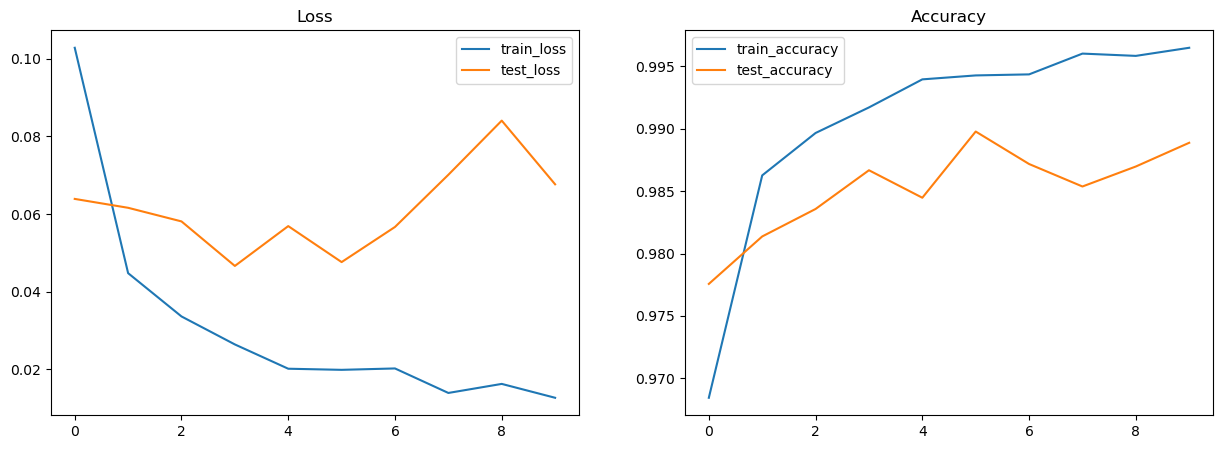

In [13]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

In [14]:
@nnx.jit
def pred_step(model: CNN, batch):
  logits = model(batch['image'])
  return logits.argmax(axis=1)

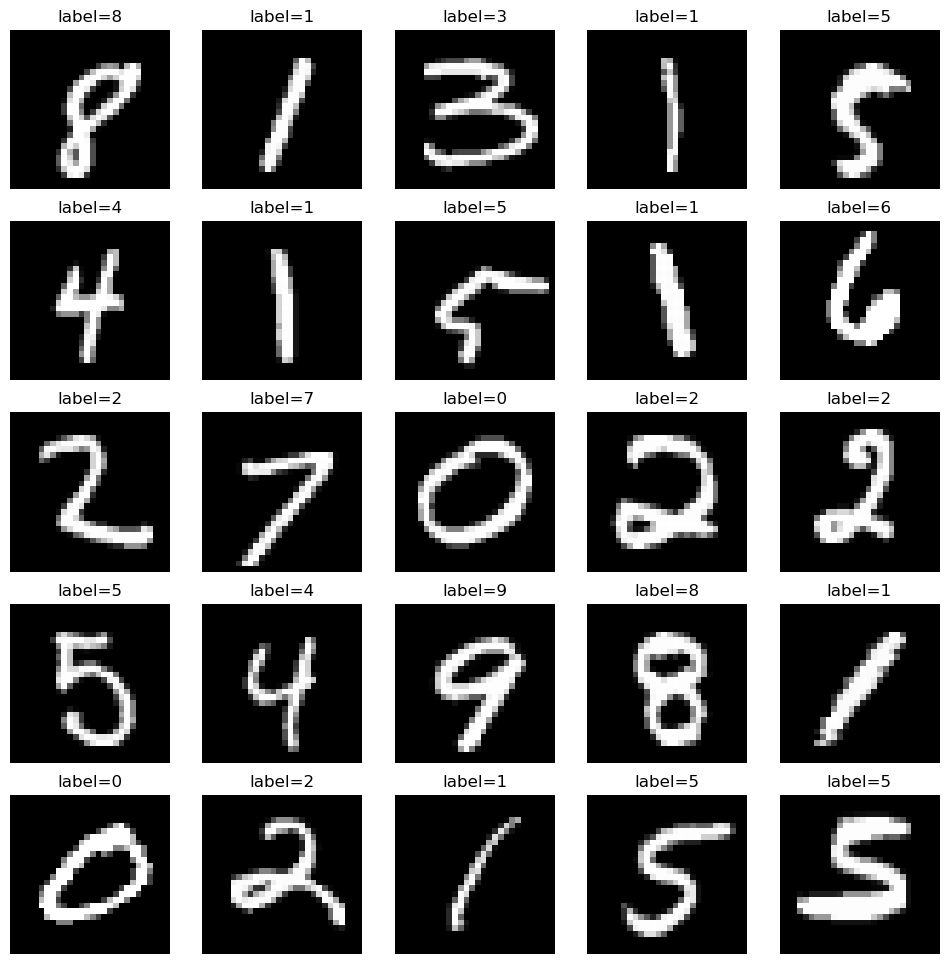

In [15]:
test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(model, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
  ax.set_title(f'label={pred[i]}')
  ax.axis('off')